In [1]:
import os
os.environ['DRJIT_LIBLLVM_PATH'] = 'C:\\Program Files\\LLVM\\bin\\LLVM-C.dll'
#print(os.environ['DRJIT_LIBLLVM_PATH'])
import sionna
import mitsuba as mi
import drjit as dr
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import display, HTML
# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera, Antenna, AntennaArray
# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement
from Movement import *
from Visualization import *
from helper import *
from Channel import *
from Codebook import *

In [2]:
#tf.random.set_seed(10)
itu_metal_scattering_coefficient = 0.707 # To define the  scattering coefficient based on Sionna R = sqrt(1-S**2)
itu_concrete_scattering_coefficient = 0.707 # To define the  scattering coefficient based on Sionna R = sqrt(1-S**2)

c = 299792458.0 # m/s
# tx and rx in cartesian coordinate
tx_position = [0,0.25,.94]
rx_position = [0,-0.25,.94]

initial_position_cartesian = [1.5,-2,0]

In [3]:
scene = load_scene('C:\\Users\\dehghani\\Documents\\test_scene\\scene.xml')

In [4]:
#scene.tx_array = AntennaArray(antenna=Antenna("iso", "V"),
                     #positions=tf.Variable([[0,0,0], [0, 1, 1], [0, 1, 3]]))
#scene.rx_array = AntennaArray(antenna=Antenna("iso", "V"),
                     #positions=tf.Variable([[0,0,0], [0, 1, 1]]))



# Create transmitter
#tx = Transmitter(name = "tx",
                 #position = tx_position)

#tx.look_at([1.5,1,0.94]) 

# Add transmitter instance to scene
#scene.add(tx)

# Create a receiver
#rx = Receiver(name = "rx",
              #position = rx_position)

#rx.look_at([1.5,1,0.94]) 

# Add receiver instance to scene
#scene.add(rx)

In [5]:
scene.frequency = 28e9
wavelength = c/scene.frequency
#print(scene.synthetic_array)
scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

scene.tx_array = PlanarArray(num_rows=1,
                          num_cols=8,
                          vertical_spacing = wavelength/2,
                          horizontal_spacing= wavelength/2,
                          pattern="iso",
                          polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                          num_cols=6,
                          vertical_spacing= wavelength/2,
                          horizontal_spacing= wavelength/2,
                          pattern="iso",
                          polarization="V")

#scene.tx_array.show()

# Create transmitter
tx = Transmitter(name = "tx",
                 position = tx_position)

#tx.look_at([1.5,1,0.94]) 

# Add transmitter instance to scene
scene.add(tx)

# Create a receiver
rx = Receiver(name = "rx",
              position = rx_position)

#rx.look_at([1.5,1,0.94]) 

# Add receiver instance to scene
scene.add(rx)


In [6]:
wavelength

<tf.Tensor: shape=(), dtype=float32, numpy=0.010706873>

In [7]:
for rm in scene.radio_materials.values():
    if rm.name=='itu_metal' :
        print(f'Before: rm.name: {rm.name} and   rm.scattering_coefficient = { rm.scattering_coefficient}')
        rm.scattering_coefficient= itu_metal_scattering_coefficient
        print(f'After: rm.name: {rm.name} and   rm.scattering_coefficient = { rm.scattering_coefficient}')
        
    if rm.name=='itu_concrete' :
        rm.scattering_coefficient = itu_concrete_scattering_coefficient

   #     rm.scattering_pattern = BackscatteringPattern(alpha_r=20, alpha_i=30, lambda_=0.5)

Before: rm.name: itu_metal and   rm.scattering_coefficient = 0.0
After: rm.name: itu_metal and   rm.scattering_coefficient = 0.7070000171661377


In [8]:
params = mi.traverse(scene._scene)
positions = dr.unravel(mi.Point3f, params['mesh-Robot.vertex_positions'])

positions.x += initial_position_cartesian[0]
positions.y += initial_position_cartesian[1]
positions.z += initial_position_cartesian[2]

params['mesh-Robot.vertex_positions'] = dr.ravel(positions)
params.update()

[(PLYMesh[
    name = "Robot.ply",
    bbox = BoundingBox3f[
      min = [0.95, -2.25, 0.84],
      max = [2.05, -1.75, 1.04]
    ],
    vertex_count = 14,
    vertices = [280 B of vertex data],
    face_count = 12,
    faces = [144 B of face data],
    face_normals = 1
  ],
  {'vertex_positions'}),
 (Scene[
    children = [
      PathIntegrator[
        max_depth = 12,
        rr_depth = 5
      ],
      TwoSided[
        brdf[0] = SmoothDiffuse[
          reflectance = SRGBReflectanceSpectrum[
            value = [[0.8, 0.043496, 0.011812]]
          ]
        ],
        brdf[1] = SmoothDiffuse[
          reflectance = SRGBReflectanceSpectrum[
            value = [[0.8, 0.043496, 0.011812]]
          ]
        ]
      ],
      ConstantBackgroundEmitter[
        radiance = SRGBReflectanceSpectrum[
          value = [[1, 1, 1]]
        ],
        bsphere = BoundingSphere3f[
          center = [0, 0, 0.94],
          radius = 0.612427
        ]
      ],
      PLYMesh[
        name = "Ro

In [9]:
scene._solver_paths = Solver(scene)
paths = scene.compute_paths(method='fibonacci', max_depth=1, num_samples=1e7, reflection=False, scattering=True,
                                    diffraction=False, los=False)
paths.normalize_delays = False
a, tau = paths.cir(los=False, reflection=False, diffraction=False, scattering=True)

In [10]:
scene.preview(paths, show_devices=True, show_paths=True) 

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [11]:
# a = [batch_size, num_rx, num_rx_ant, num_tx, num_tx_ant, max_num_paths, num_time_steps], tf.complex
a

<tf.Tensor: shape=(1, 1, 6, 1, 8, 26, 1), dtype=complex64, numpy=
array([[[[[[[ 3.62165520e-06-4.8621441e-06j],
            [ 5.87599834e-06-1.3038583e-06j],
            [-5.50005552e-08+3.7721700e-06j],
            ...,
            [-5.96266830e-07-4.5061884e-06j],
            [-1.62314939e-06+3.8307103e-06j],
            [-2.28466388e-06+5.6753279e-06j]],

           [[ 3.47407899e-06-4.9686628e-06j],
            [ 5.83435394e-06-1.4790958e-06j],
            [ 3.52406460e-08+3.7724062e-06j],
            ...,
            [-7.14462942e-07-4.4889653e-06j],
            [-1.52630810e-06+3.8703151e-06j],
            [-2.11260249e-06+5.7415973e-06j]],

           [[ 3.32337163e-06-5.0707040e-06j],
            [ 5.78748359e-06-1.6530084e-06j],
            [ 1.25461497e-07+3.7704842e-06j],
            ...,
            [-8.32165881e-07-4.4686426e-06j],
            [-1.42850104e-06+3.9074725e-06j],
            [-1.93862252e-06+5.8026526e-06j]],

           ...,

           [[ 2.85383703e-06-5.3

In [12]:
# a_reshaped = [num_rx_ant, num_tx_ant, max_num_paths], tf.complex
a_reshaped = tf.squeeze(a, [0,1,3,6])
a_reshaped = tf.transpose(a_reshaped, perm=[2, 0, 1])
a_reshaped

<tf.Tensor: shape=(26, 6, 8), dtype=complex64, numpy=
array([[[ 3.62165520e-06-4.8621441e-06j,  3.47407899e-06-4.9686628e-06j,
          3.32337163e-06-5.0707040e-06j, ...,
          2.85383703e-06-5.3490603e-06j,  2.69199131e-06-5.4323127e-06j,
          2.52771929e-06-5.5106684e-06j],
        [ 3.48463368e-06-4.9612663e-06j,  3.33414346e-06-5.0636272e-06j,
          3.18064895e-06-5.1614252e-06j, ...,
          2.70353326e-06-5.4265779e-06j,  2.53942835e-06-5.5052824e-06j,
          2.37303493e-06-5.5790274e-06j],
        [ 3.34490051e-06-5.0565286e-06j,  3.19161427e-06-5.1546517e-06j,
          3.03545130e-06-5.2481300e-06j, ...,
          2.55112582e-06-5.4998723e-06j,  2.38488951e-06-5.5739692e-06j,
          2.21650407e-06-5.6430440e-06j],
        [ 3.20256459e-06-5.1478555e-06j,  3.04660125e-06-5.2416649e-06j,
          2.88789215e-06-5.3307517e-06j, ...,
          2.39673318e-06-5.5688865e-06j,  2.22849508e-06-5.6383187e-06j,
          2.05824836e-06-5.7026700e-06j],
        [ 

# Receiving Codebook


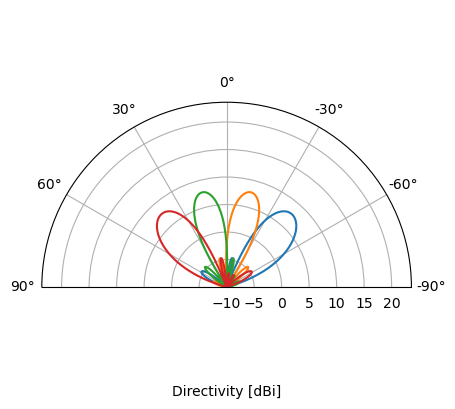

In [13]:
receiving_codebook = Codebook(L_max = 4, N1 = 6)
receiving_codebook_vectors = receiving_codebook.beamforming_vectors()
receiving_codebook.plot_beamforming_polar(receiving_codebook_vectors)

In [14]:
receiving_matrix = np.vstack(receiving_codebook_vectors).T # converting the list into a matrix
receiving_codebook_matrix = np.reshape(receiving_matrix, (1, 6, 4)).astype(np.complex64)
receiving_codebook_matrix.shape  # (batch size, number of antennas, number of beams) 

(1, 6, 4)

# Transmitting Codebook

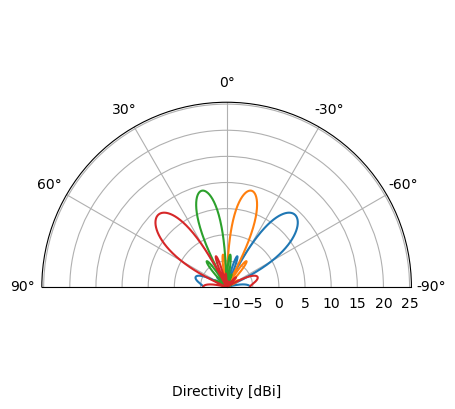

In [15]:
transmitting_codebook = Codebook(L_max = 4, N1 = 8)
transmitting_codebook_vectors = transmitting_codebook.beamforming_vectors()
transmitting_codebook.plot_beamforming_polar(transmitting_codebook_vectors)

In [16]:
transmitting_matrix = np.vstack(transmitting_codebook_vectors).T # converting the list into a matrix
transmitting_codebook_matrix = np.reshape(transmitting_matrix, (1, 8, 4)).astype(np.complex64)
transmitting_codebook_matrix.shape # (batch size, number of antennas, number of beams)

(1, 8, 4)

In [36]:
transmitting_signal = tf.matmul(a_reshaped, transmitting_codebook_matrix )
print(transmitting_signal.shape)
receiving_signal = tf.matmul(receiving_codebook_matrix, transmitting_signal, adjoint_a=True)
receiving_signal.shape

(26, 6, 4)


TensorShape([26, 4, 4])

In [33]:
diag_receiving_signal = tf.linalg.diag_part(receiving_signal)
#diag_receiving_signal

In [37]:
# tau = [batch_size, num_rx, num_tx, max_num_paths]
tau = tf.squeeze(tau)
tau

<tf.Tensor: shape=(26,), dtype=float32, numpy=
array([1.35080409e-08, 1.35609319e-08, 1.76590991e-08, 1.42714356e-08,
       1.75182109e-08, 1.43270720e-08, 1.35851499e-08, 1.38615253e-08,
       1.66550578e-08, 1.33553844e-08, 1.46225272e-08, 1.58257265e-08,
       1.35533309e-08, 1.46171466e-08, 1.43228327e-08, 1.41223193e-08,
       1.35658782e-08, 1.47278465e-08, 1.61234510e-08, 1.61056963e-08,
       1.36186502e-08, 1.36803013e-08, 1.47324002e-08, 1.58501035e-08,
       1.66781327e-08, 1.34423939e-08], dtype=float32)>

In [24]:
# Reshape the tensor to a 2D array
reshaped_array = tf.reshape(receiving_signal, (tau.shape[0], 16))
columns = ['1,1', '1,2', '1,3', '1,4','2,1', '2,2', '2,3', '2,4','3,1', '3,2', '3,3', '3,4','4,1', '4,2', '4,3', '4,4']
df1 = pd.DataFrame(reshaped_array.numpy(), columns=columns)
df1 = df1.set_index(pd.Index(tau))
df1

,"1,1","1,2","1,3","1,4","2,1","2,2","2,3","2,4","3,1","3,2","3,3","3,4","4,1","4,2","4,3","4,4"
1.350804e-08,5.671401e-08-1.675608e-08j,4.835869e-09+2.526942e-08j,-2.288851e-08-1.553484e-08j,-4.901381e-08+5.884851e-08j,1.147062e-06-5.097384e-07j,1.717808e-07+5.183639e-07j,-5.247081e-07-2.635025e-07j,-8.684058e-07+1.374198e-06j,-3.560855e-07+9.256879e-07j,-3.855973e-07-1.936426e-07j,4.403894e-07-1.459408e-07j,-2.825963e-07-1.252988e-06j,1.362474e-08-5.657591e-08j,2.391400e-08+8.311304e-09j,-2.450032e-08+1.186235e-08j,2.603474e-08+7.072333e-08j
1.356093e-08,5.323955e-08+2.413549e-08j,-1.267512e-08+2.194379e-08j,-7.044690e-09-2.631374e-08j,-7.463214e-08+1.230734e-08j,1.192415e-06+3.619731e-07j,-2.068318e-07+4.990583e-07j,-2.221250e-07-5.365575e-07j,-1.543156e-06+4.677785e-07j,-8.694630e-07+4.645165e-07j,-1.634597e-07-3.948470e-07j,4.243765e-07+1.758809e-07j,6.015234e-07-1.124836e-06j,4.676554e-08-3.349777e-08j,1.246562e-08+2.159959e-08j,-2.589244e-08-6.943651e-09j,-2.623381e-08+6.966098e-08j
1.765910e-08,-1.776841e-08+2.117454e-08j,-6.542578e-09-6.687383e-09j,9.911474e-09+1.084572e-10j,3.696044e-09-3.374058e-08j,-4.208706e-07+6.606028e-07j,-2.085437e-07-1.636735e-07j,2.788501e-07-3.361485e-08j,-2.096132e-08-9.615885e-07j,-1.428177e-07-6.442755e-07j,2.217444e-07-2.673124e-08j,-1.460961e-07+1.861477e-07j,5.853430e-07+5.603682e-07j,9.343140e-09+2.567188e-08j,-8.957066e-09+2.295550e-09j,4.990667e-09-8.429883e-09j,-2.705293e-08-1.983699e-08j
1.427144e-08,-4.543837e-08+2.159504e-08j,-7.049252e-09-1.958578e-08j,2.018601e-08+9.501363e-09j,3.300752e-08-5.530336e-08j,-9.525764e-07+6.167098e-07j,-2.153098e-07-4.172526e-07j,4.793998e-07+1.530465e-07j,5.753365e-07-1.333965e-06j,1.905736e-07-8.904290e-07j,3.589229e-07+1.145848e-07j,-3.588567e-07+1.851761e-07j,4.304534e-07+1.083358e-06j,-3.957950e-09+4.939932e-08j,-2.018064e-08-3.632636e-09j,1.804750e-08-1.254094e-08j,-3.092148e-08-5.539704e-08j
1.751821e-08,2.030981e-08+1.964176e-08j,-7.345896e-09+6.237002e-09j,8.310224e-10-1.017976e-08j,-3.418583e-08-6.207870e-09j,6.378442e-07+4.727077e-07j,-1.817747e-07+2.006997e-07j,-1.418418e-08-2.866510e-07j,-9.751503e-07-4.756004e-08j,-6.605609e-07+9.822429e-08j,-1.125705e-08-2.274975e-07j,1.789379e-07+1.620651e-07j,6.083121e-07-5.517350e-07j,2.684510e-08-7.676277e-09j,1.708038e-09+9.368513e-09j,-8.301864e-09-5.740844e-09j,-2.220406e-08+2.618926e-08j
1.432707e-08,-1.483426e-08-4.747919e-08j,2.007958e-08-4.167731e-09j,-1.205696e-08+1.837235e-08j,4.951920e-08+3.995666e-08j,-4.735430e-07-1.022486e-06j,4.386592e-07-1.529740e-07j,-2.164637e-07+4.482808e-07j,1.230302e-06+7.509727e-07j,8.497465e-07+3.118003e-07j,-1.622697e-07+3.360485e-07j,-1.316722e-07-3.775762e-07j,-1.125367e-06+2.722593e-07j,-4.781349e-08-1.073067e-08j,6.335000e-09-1.918406e-08j,9.735913e-09+1.933564e-08j,5.848000e-08-2.256593e-08j
1.358515e-08,4.428415e-08+3.768153e-08j,-1.810924e-08+1.747691e-08j,4.808953e-10-2.704611e-08j,-7.470641e-08-8.702159e-09j,1.042899e-06+6.745332e-07j,-3.347841e-07+4.205918e-07j,-6.521677e-08-5.741111e-07j,-1.606383e-06+2.399418e-08j,-9.611633e-07+2.061565e-07j,-4.802232e-08-4.227472e-07j,3.578004e-07+2.848035e-07j,8.855839e-07-9.124420e-07j,5.390649e-08-1.920094e-08j,5.983665e-09+2.403434e-08j,-2.281389e-08-1.371805e-08j,-4.417768e-08+5.938884e-08j
1.386153e-08,-4.434787e-08-1.486023e-08j,8.515400e-09-1.899150e-08j,7.976638e-09+2.094455e-08j,5.876035e-08-1.599142e-08j,-9.440927e-07-1.839486e-07j,1.226413e-07-4.100721e-07j,2.188532e-07+4.056139e-07j,1.155127e-06-4.837816e-07j,6.249263e-07-4.211139e-07j,1.592347e-07+2.951193e-07j,-3.459492e-07-1.034639e-07j,-3.719202e-07+9.079424e-07j,-3.446337e-08+3.046336e-08j,-1.198770e-08-1.659109e-08j,2.176030e-08+3.505278e-09j,1.527377e-08-5.790962e-08j
1.665506e-08,-2.077032e-08+2.495707e-08j,-8.162360e-09-8.274924e-09j,1.235157e-08+8.486722e-11j,4.225825e-09-4.008587e-08j,-4.618124e-07+7.314154e-07j,-2.443668e-07-1.901870e-07j,3.265410e-07-4.071249e-08j,-2.777108e-08-1.073495e-06j,-1.587138e-07-7.024465e-07j,2.558191e-07-3

In [25]:
channel_magnitude_df = abs_complex_columns(df1)
channel_magnitude_df

,"1,1","1,2","1,3","1,4","2,1","2,2","2,3","2,4","3,1","3,2","3,3","3,4","4,1","4,2","4,3","4,4"
1.350804e-08,5.913751e-08,2.572799e-08,2.766252e-08,7.658656e-08,1.255223e-06,5.460858e-07,5.871560e-07,1.625592e-06,9.918140e-07,4.314890e-07,4.639413e-07,1.284461e-06,5.819336e-08,2.531714e-08,2.722097e-08,7.536310e-08
1.356093e-08,5.845486e-08,2.534144e-08,2.724042e-08,7.564011e-08,1.246145e-06,5.402208e-07,5.807180e-07,1.612497e-06,9.857694e-07,4.273444e-07,4.593795e-07,1.275573e-06,5.752492e-08,2.493860e-08,2.680733e-08,7.443699e-08
1.765910e-08,2.764196e-08,9.355556e-09,9.912068e-09,3.394241e-08,7.832804e-07,2.651028e-07,2.808689e-07,9.618169e-07,6.599150e-07,2.233498e-07,2.366327e-07,8.103326e-07,2.731922e-08,9.246545e-09,9.796412e-09,3.354650e-08
1.427144e-08,5.030896e-08,2.081573e-08,2.231033e-08,6.440464e-08,1.134783e-06,4.695296e-07,5.032369e-07,1.452747e-06,9.105943e-07,3.767696e-07,4.038171e-07,1.165742e-06,4.955762e-08,2.050498e-08,2.197697e-08,6.344265e-08
1.751821e-08,2.825398e-08,9.636513e-09,1.021362e-08,3.474491e-08,7.939130e-07,2.707811e-07,2.870018e-07,9.763094e-07,6.678239e-07,2.277758e-07,2.414205e-07,8.212522e-07,2.792104e-08,9.522942e-09,1.009348e-08,3.433508e-08
1.432707e-08,4.974262e-08,2.050754e-08,2.197529e-08,6.362929e-08,1.126818e-06,4.645675e-07,4.978074e-07,1.441389e-06,9.051456e-07,3.731756e-07,3.998766e-07,1.157832e-06,4.900282e-08,2.020298e-08,2.164844e-08,6.268278e-08
1.358515e-08,5.814623e-08,2.516718e-08,2.705039e-08,7.521153e-08,1.242028e-06,5.375666e-07,5.778034e-07,1.606562e-06,9.830236e-07,4.254660e-07,4.573119e-07,1.271538e-06,5.722400e-08,2.476799e-08,2.662064e-08,7.401825e-08
1.386153e-08,4.677136e-08,2.081320e-08,2.241207e-08,6.089749e-08,9.618462e-07,4.280187e-07,4.608897e-07,1.252343e-06,7.535714e-07,3.353373e-07,3.610895e-07,9.811647e-07,4.599718e-08,2.046874e-08,2.204082e-08,5.989000e-08
1.665506e-08,3.246939e-08,1.162319e-08,1.235186e-08,4.030799e-08,8.650082e-07,3.096550e-07,3.290692e-07,1.073854e-06,7.201536e-07,2.577998e-07,2.739629e-07,8.940251e-07,3.206406e-08,1.147838e-08,1.219826e-08,3.980586e-08
1.335538e-08,6.117625e-08,2.688946e-08,2.893106e-08,7.941895e-08,1.282109e-06,5.635384e-07,6.063257e-07,1.664436e-06,1.009648e-06,4.437810e-07,4.774761e-07,1.310727e-06,6.018537e-08,2.645374e-08,2.846230e-08,7.813206e-08


In [26]:
m = channel_magnitude_df.query('index > 11e-9').max()
m

1,1    6.117625e-08
1,2    2.688946e-08
1,3    2.893106e-08
1,4    7.941895e-08
2,1    1.282109e-06
2,2    5.635384e-07
2,3    6.063257e-07
2,4    1.664436e-06
3,1    1.009648e-06
3,2    4.437810e-07
3,3    4.774761e-07
3,4    1.310727e-06
4,1    6.018537e-08
4,2    2.645374e-08
4,3    2.846230e-08
4,4    7.813206e-08
dtype: float64

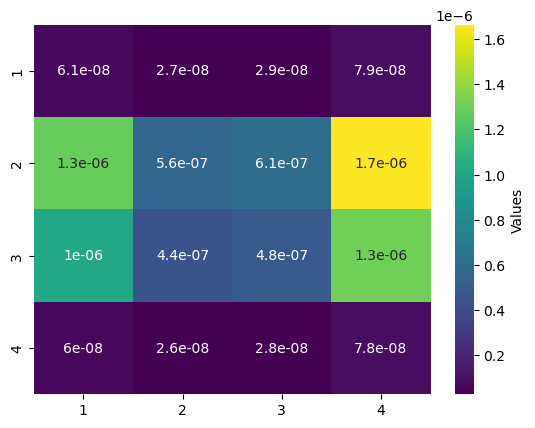

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reshape the data into a 2D array --> 4*4
data_matrix = m.values.reshape(4, 4)

# Convert index labels to integers
index_labels = [tuple(map(int, index.split(','))) for index in m.index]
rows, cols = zip(*index_labels)

# Create a heatmap using seaborn
sns.heatmap(data_matrix, cmap='viridis', annot=True, cbar_kws={'label': 'Values'})

plt.xticks(np.arange(4) + 0.5, range(1, 5))
plt.yticks(np.arange(4) + 0.5, range(1, 5))

# Display the heatmap
plt.show()

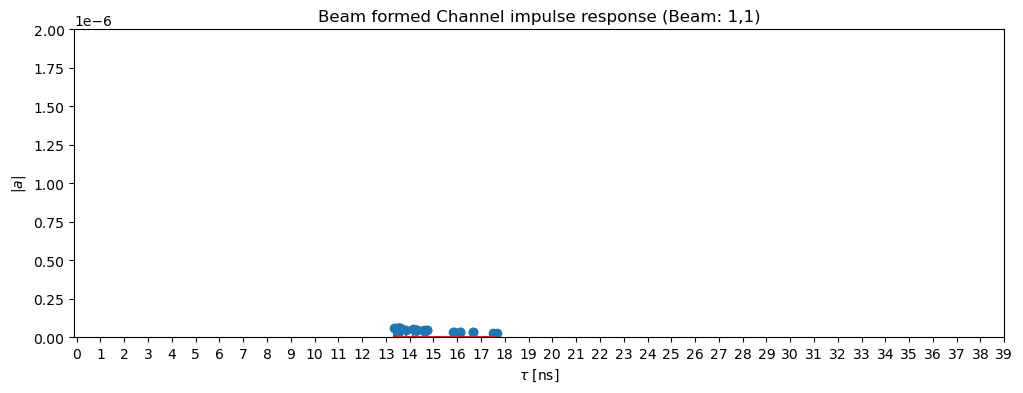

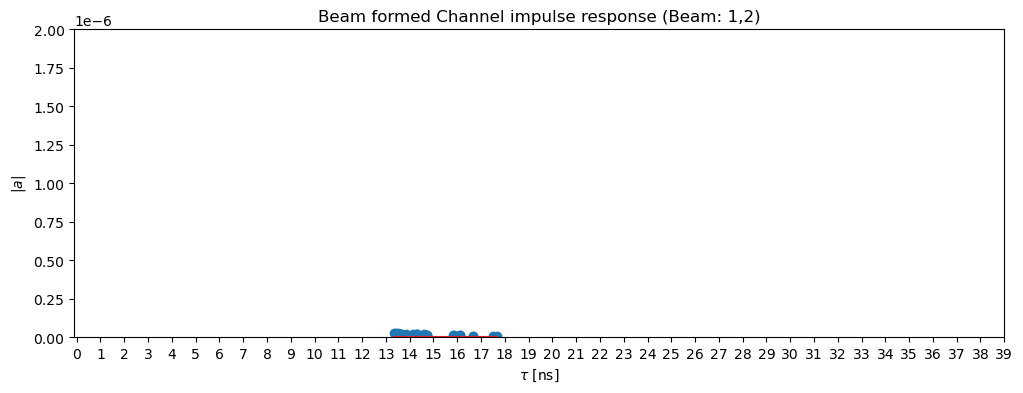

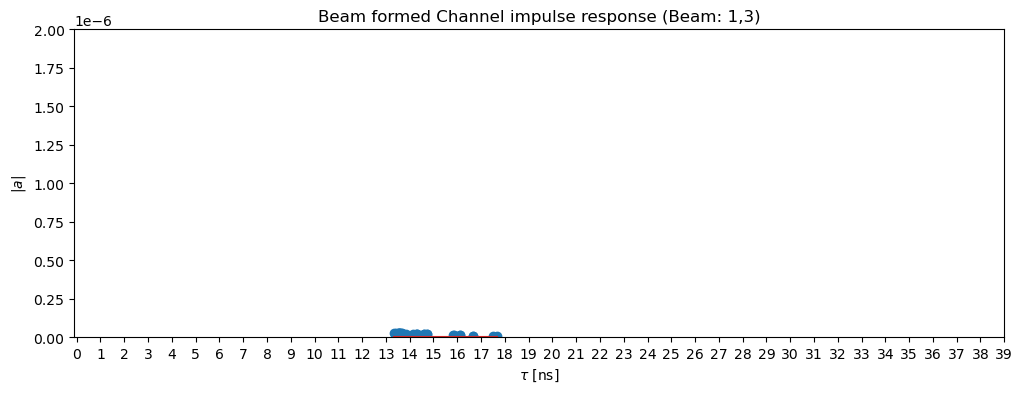

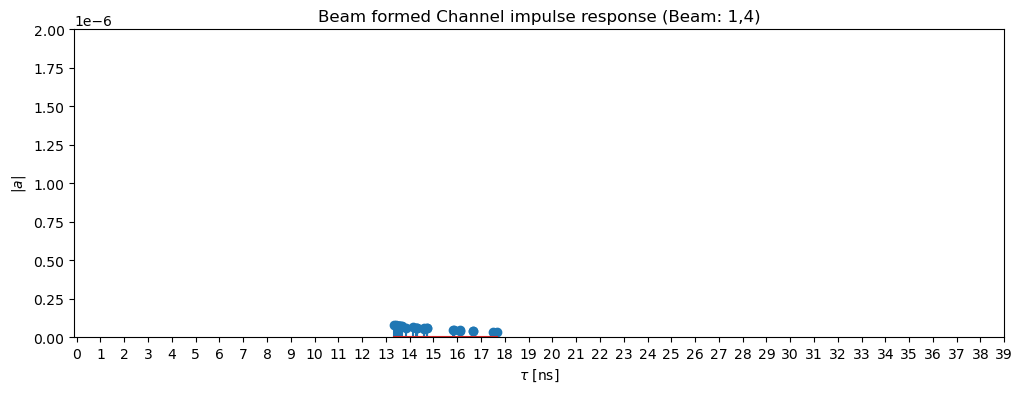

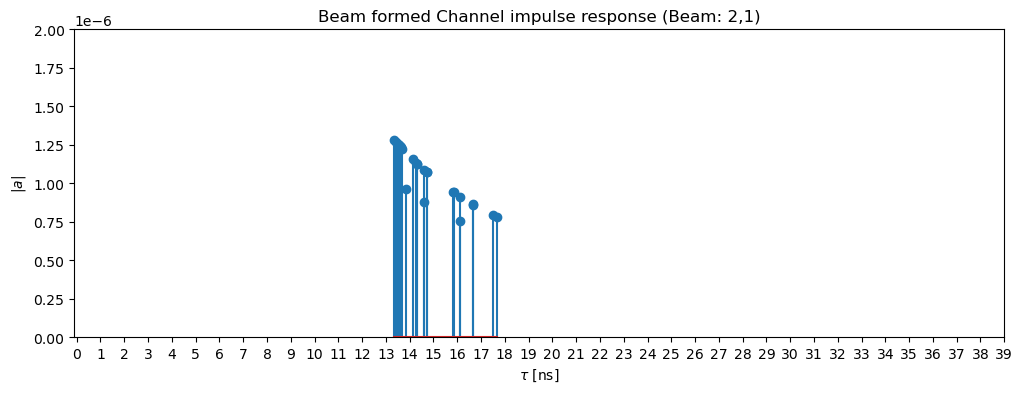

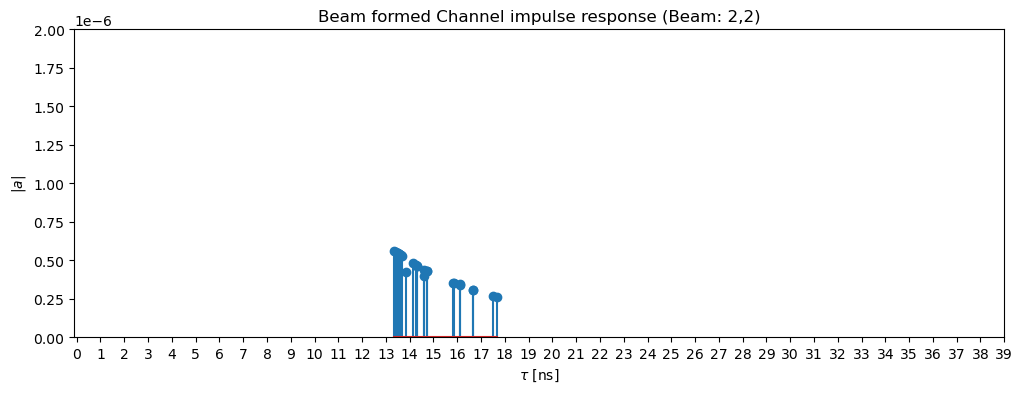

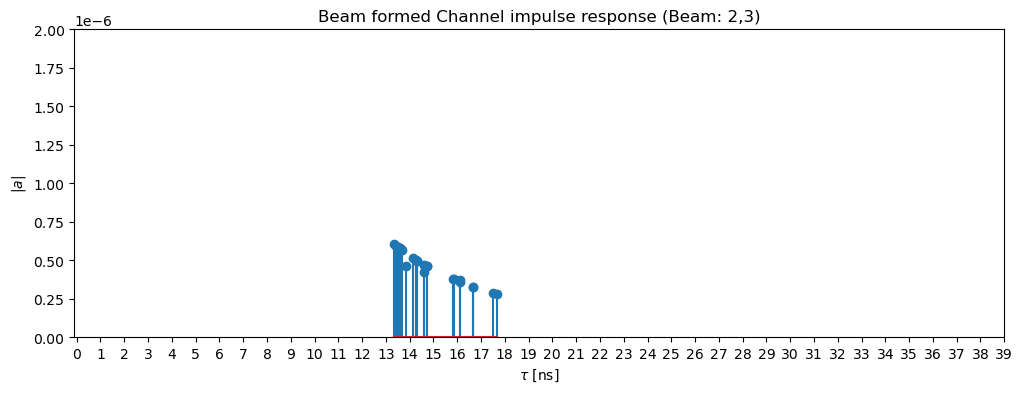

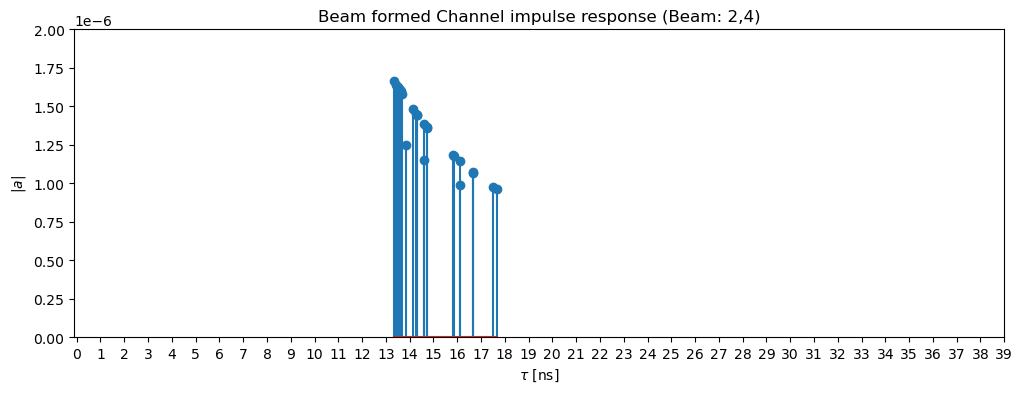

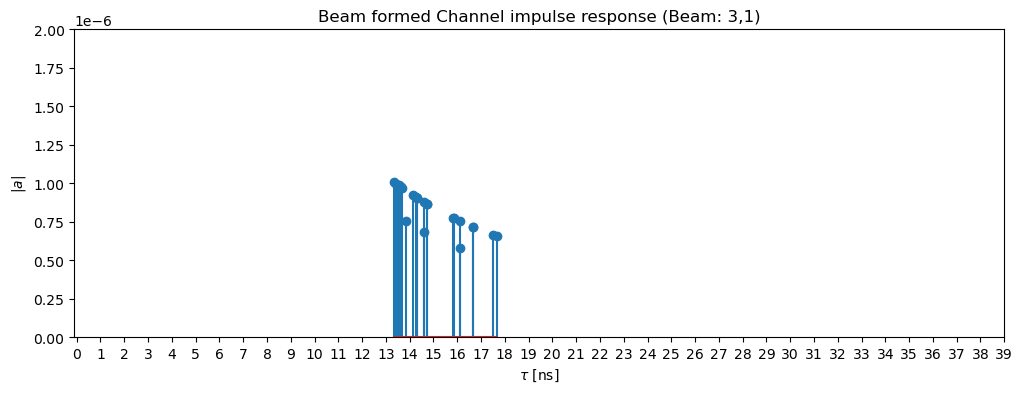

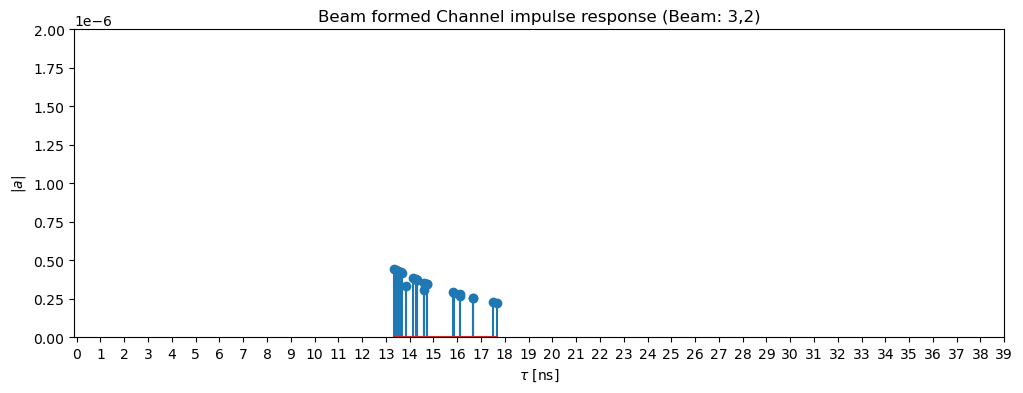

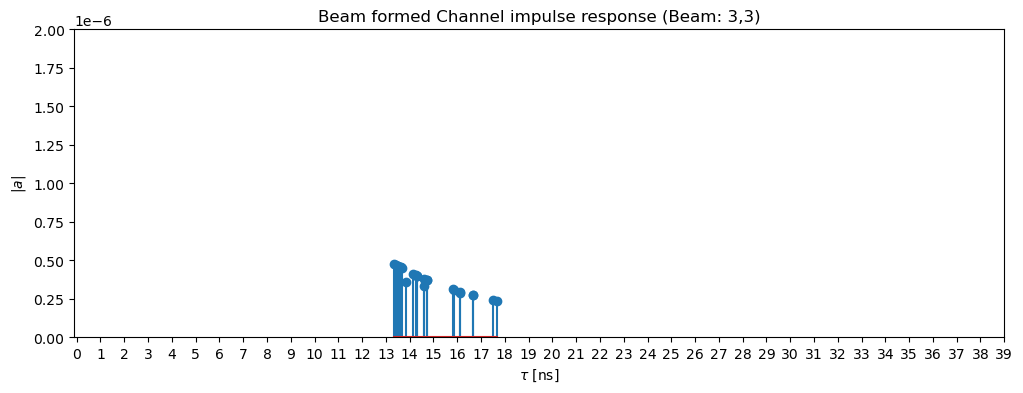

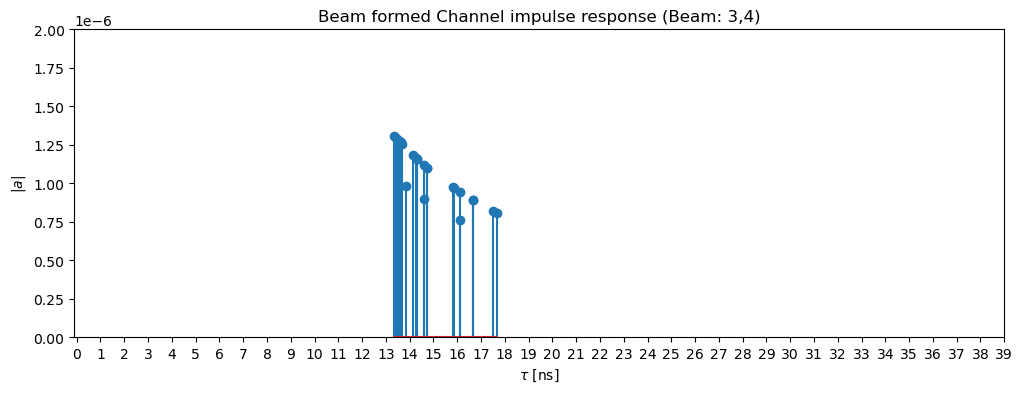

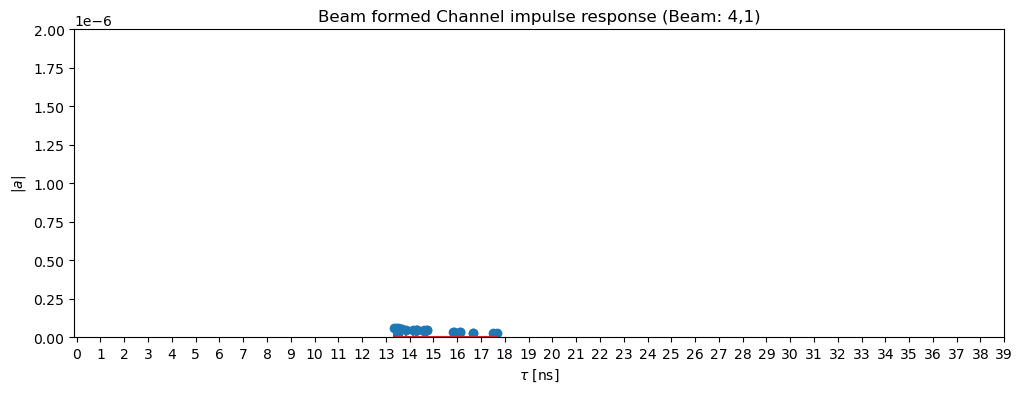

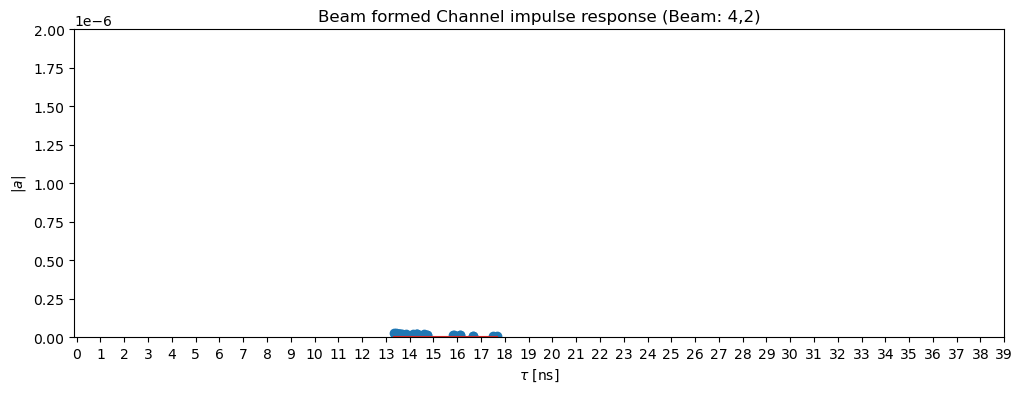

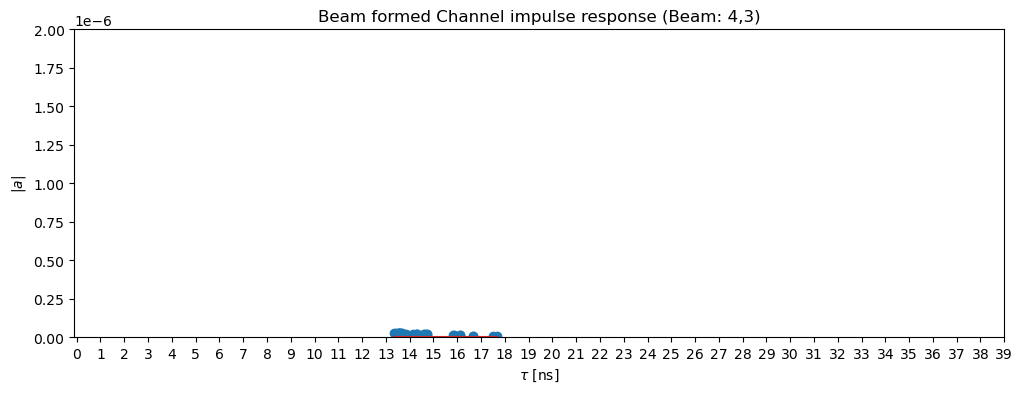

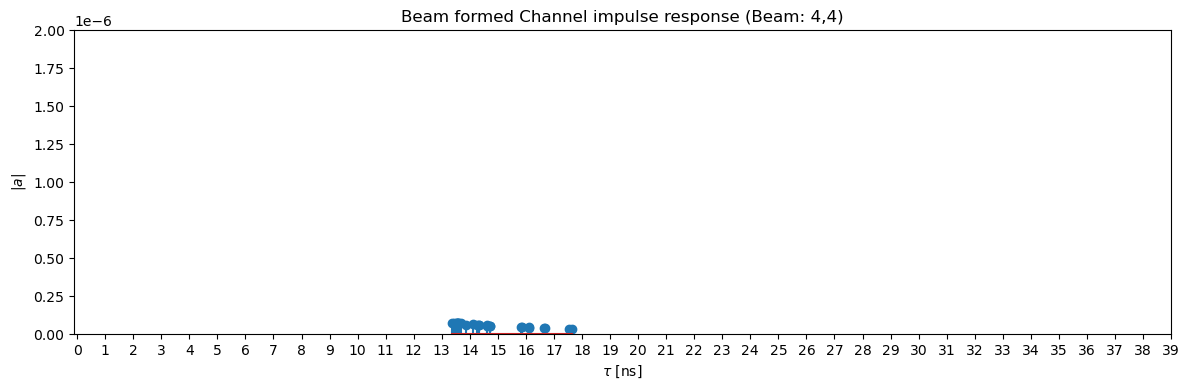

In [28]:
for column in channel_magnitude_df.columns:
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))   
    ax.set_title(f"Beam formed Channel impulse response (Beam: {column})")
    ax.stem(channel_magnitude_df.index*1e9, channel_magnitude_df[column])
    ax.set_xlim([-0.1, 39])
    ax.set_ylim([-2e-12, 2e-6])
    ax.set_xlabel(r"$\tau$ [ns]")
    ax.set_ylabel(r"$|a|$")
    ax.set_xticks(np.arange(0, 40, 1))

# subplots do not overlap
plt.tight_layout()
plt.show()

In [29]:
receiving_signal[:,0,1]

<tf.Tensor: shape=(26,), dtype=complex64, numpy=
array([ 4.8358686e-09+2.5269422e-08j, -1.2675116e-08+2.1943791e-08j,
       -6.5425780e-09-6.6873831e-09j, -7.0492518e-09-1.9585777e-08j,
       -7.3458963e-09+6.2370020e-09j,  2.0079575e-08-4.1677310e-09j,
       -1.8109240e-08+1.7476907e-08j,  8.5153999e-09-1.8991500e-08j,
       -8.1623597e-09-8.2749239e-09j, -3.6110066e-09-2.6645893e-08j,
       -1.2672231e-08-1.4989507e-08j,  6.5278698e-09+1.2462230e-08j,
        2.0751287e-08-1.4640477e-08j, -1.8566951e-08+4.0223256e-09j,
        9.1686445e-09-1.8370116e-08j, -2.1618632e-08-1.5098749e-09j,
       -1.9432612e-08+1.6208332e-08j,  1.7395244e-08-6.1752417e-09j,
        5.1700937e-09+1.2057420e-08j, -1.5863932e-08-7.3359132e-09j,
       -1.4552370e-08+2.0238161e-08j,  2.1654351e-08-1.1452130e-08j,
        6.3704846e-09-1.7302156e-08j,  1.1258621e-08+8.2994447e-09j,
       -4.4602331e-09-1.0668586e-08j, -1.1344184e-08-2.3637696e-08j],
      dtype=complex64)>

In [30]:
#df1['1,1'] == receiving_signal[:,0,0]
df1['1,1']

1.350804e-08    5.671401e-08-1.675608e-08j
1.356093e-08    5.323955e-08+2.413549e-08j
1.765910e-08   -1.776841e-08+2.117454e-08j
1.427144e-08   -4.543837e-08+2.159504e-08j
1.751821e-08    2.030981e-08+1.964176e-08j
1.432707e-08   -1.483426e-08-4.747919e-08j
1.358515e-08    4.428415e-08+3.768153e-08j
1.386153e-08   -4.434787e-08-1.486023e-08j
1.665506e-08   -2.077032e-08+2.495707e-08j
1.335538e-08   -5.952491e-08+1.411803e-08j
1.462253e-08   -3.039931e-08+3.129966e-08j
1.582573e-08    3.130346e-08-2.054105e-08j
1.355333e-08   -3.828046e-08-4.430461e-08j
1.461715e-08    1.438741e-08+4.467935e-08j
1.432283e-08   -4.651022e-08-1.775905e-08j
1.412232e-08    1.476337e-09+5.185207e-08j
1.356588e-08    4.161649e-08+4.095904e-08j
1.472785e-08   -1.953384e-08-4.156847e-08j
1.612345e-08    3.113044e-08-1.713792e-08j
1.610570e-08   -1.256637e-08+3.610066e-08j
1.361865e-08    4.994195e-08+2.894319e-08j
1.368030e-08   -3.143350e-08-4.749691e-08j
1.473240e-08   -4.441009e-08-1.155820e-08j
1.585010e-0

In [31]:
receiving_signal[:,0,0]

<tf.Tensor: shape=(26,), dtype=complex64, numpy=
array([ 5.67140148e-08-1.6756076e-08j,  5.32395461e-08+2.4135488e-08j,
       -1.77684143e-08+2.1174543e-08j, -4.54383695e-08+2.1595042e-08j,
        2.03098125e-08+1.9641760e-08j, -1.48342565e-08-4.7479190e-08j,
        4.42841497e-08+3.7681531e-08j, -4.43478712e-08-1.4860234e-08j,
       -2.07703152e-08+2.4957075e-08j, -5.95249077e-08+1.4118029e-08j,
       -3.03993062e-08+3.1299663e-08j,  3.13034576e-08-2.0541052e-08j,
       -3.82804615e-08-4.4304613e-08j,  1.43874104e-08+4.4679354e-08j,
       -4.65102232e-08-1.7759049e-08j,  1.47633727e-09+5.1852069e-08j,
        4.16164880e-08+4.0959037e-08j, -1.95338430e-08-4.1568470e-08j,
        3.11304404e-08-1.7137921e-08j, -1.25663746e-08+3.6100658e-08j,
        4.99419457e-08+2.8943191e-08j, -3.14335011e-08-4.7496911e-08j,
       -4.44100863e-08-1.1558200e-08j,  1.90723739e-08-3.2031920e-08j,
       -2.84752701e-08+1.5340817e-08j, -5.12901437e-08+3.1137404e-08j],
      dtype=complex64)>